# Разведывательный анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np

from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

import statsmodels.formula.api as smf

# Цель проекта
Отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

# Задачи проекта
1. Провести первичную обработку данных.
2. Устраните выбросы и лишние данные.
3. Преобразовать необходимые данные.
4. Провести корреляционный анализ количественных переменных.
5. Отобрать не коррелирующие переменные.
6. Проанализировать номинативные переменные и устранить те, которые не влияют на предсказываемую величину (в нашем случае — на переменную score).
7. Сделать выводы.

# Первичный отсмотр данных

In [2]:
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

df = pd.read_csv('stud_math.csv')

In [3]:
display(df.head(10))
df.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

# Содержание датасета

1. **school** — аббревиатура школы, в которой учится ученик

2. **sex** — пол ученика ('F' - женский, 'M' - мужской)

3. **age** — возраст ученика (от 15 до 22)

4. **address** — тип адреса ученика ('U' - городской, 'R' - за городом)

5. **famsize** — размер семьи('LE3' <= 3, 'GT3' >3)

6. **Pstatus** — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

7. **Medu** — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

8. **Fedu** — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

9. **Mjob** — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

10. **Fjob** — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

11. **reason** — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

12. **guardian** — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

13. **traveltime** — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

14. **studytime** — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

15. **failures** — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

16. **schoolsup** — дополнительная образовательная поддержка (yes или no)

17. **famsup** — семейная образовательная поддержка (yes или no)

18. **paid** — дополнительные платные занятия по математике (yes или no)

19. **activities** — дополнительные внеучебные занятия (yes или no)

20. **nursery** — посещал детский сад (yes или no)

21. **higher** — хочет получить высшее образование (yes или no)

22. **internet** — наличие интернета дома (yes или no)

23. **romantic** — в романтических отношениях (yes или no)

24. **famrel** — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

25. **freetime** — свободное время после школы (от 1 - очень мало до 5 - очень мого)

26. **goout** — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

27. **health** — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

28. **absences** — количество пропущенных занятий

29. **score** — баллы по госэкзамену по математике

# Вспомогательные функции

In [4]:
def info_column(DF, col):
    # функция для вывода информации о колонке
    # col - имя колонки, n - для определения числа значений, встретившихся более n раз
    display(pd.DataFrame(DF[col].value_counts()))
    print('Уникальных значений:', DF[col].nunique())
    DF.loc[:, [col]].info()

In [5]:
def get_boxplot(DF, column, parameter):
    # функция для быстрого построения боксплота
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxplot(x=column, y=parameter,
                data=DF.loc[DF.loc[:, column].isin(
                    DF.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=90)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [6]:
def brute_force(params: set, formula: str, result: set) -> str:
    # Функция для нахождения набора переменных, обеспечивающих максимальный R-squared
    if not params:
        result.add(formula.lstrip('+ '))
        return
    else:
        new_params = params.copy()
        for el in params:
            new_params.remove(el)
            brute_force(new_params, formula + ' + ' + el, result)
            brute_force(new_params, formula, result)

In [7]:
def get_stat_dif(DF, column, parameter):
    # Функция для множественного сравнения в классическом варианте дисперсионного анализа
    cols = DF.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(DF.loc[DF.loc[:, column] == comb[0], parameter],
                     DF.loc[DF.loc[:, column] == comb[1], parameter]).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            print(comb[1], comb[0])
            # break

In [8]:
def find_razl(DataFrame, columns_in, columns_predict, most_popularnum, alpha):
    # Используем критерий Тьюки для множественных сравнений ANOVA (однофакторного дисперсионного анализа)
    result = pd.DataFrame()
    for col in columns_in:
        df = DataFrame.loc[DataFrame.loc[:, col].isin(
            DataFrame.loc[:, col].value_counts().index[:most_popularnum])]
        df = df[[columns_predict, col]]
        df = df.dropna()  # statsmodels не может работать с пустыми значениями

        MultiComp = MultiComparison(df[columns_predict], df[col])
        MC = pd.DataFrame(MultiComp.tukeyhsd(alpha).summary())
        MC = MC.loc[1:]

        MC.columns = ['group1', 'group2', 'meandiff',
                      'p-adj', 'lower', 'upper', 'reject']
        MC.group1 = MC.group1.astype('str')
        MC.group2 = MC.group2.astype('str')
        MC.meandiff = MC.meandiff.astype('str')
        MC.meandiff = MC.meandiff.astype('float64')
        MC['p-adj'] = MC['p-adj'].astype('str')
        MC['p-adj'] = MC['p-adj'].astype('float64')
        MC['lower'] = MC['lower'].astype('str')
        MC['lower'] = MC['lower'].astype('float64')
        MC['upper'] = MC['upper'].astype('str')
        MC['upper'] = MC['upper'].astype('float64')
        MC['reject'] = MC['reject'].astype('str')
        MC[MC.reject == 'True']
        MC.reject = MC.reject.apply(lambda x: True if x == 'True' else False)
        MC['feature'] = col  # Признак, по которому найдено различие в группах
        result = result.append(MC)
    display(result[result.reject == True])
    print(
        f"Найдены статистически значимые различия в: \n{result[result.reject == True].feature.value_counts()}")

# Анализ данных в столбцах

Переименуем некоторые столбцы

In [9]:
df.rename(columns={'studytime, granular': 'granular'}, inplace=True)

## Рассмотрим столбцы

### Категориальные столбцы:

In [10]:
for col in df.columns:
    if df[col].dtype == 'object':
        info_column(df, col)

,school
GP,349
MS,46


Уникальных значений: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   school  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,sex
F,208
M,187


Уникальных значений: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,address
U,295
R,83


Уникальных значений: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,famsize
GT3,261
LE3,107


Уникальных значений: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   famsize  368 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,Pstatus
T,314
A,36


Уникальных значений: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pstatus  350 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,Mjob
other,133
services,98
at_home,58
teacher,55
health,32


Уникальных значений: 5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Mjob    376 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,Fjob
other,197
services,102
teacher,29
at_home,16
health,15


Уникальных значений: 5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Fjob    359 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,reason
course,137
home,104
reputation,103
other,34


Уникальных значений: 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,guardian
mother,250
father,86
other,28


Уникальных значений: 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guardian  364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,schoolsup
no,335
yes,51


Уникальных значений: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   schoolsup  386 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,famsup
yes,219
no,137


Уникальных значений: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   famsup  356 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,paid
no,200
yes,155


Уникальных значений: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   paid    355 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,activities
yes,195
no,186


Уникальных значений: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  381 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,nursery
yes,300
no,79


Уникальных значений: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nursery  379 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,higher
yes,356
no,19


Уникальных значений: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   higher  375 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,internet
yes,305
no,56


Уникальных значений: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   internet  361 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


,romantic
no,240
yes,124


Уникальных значений: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   romantic  364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


### Числовые столбцы

In [11]:
for col in df.columns:
    if df[col].dtype != 'object':
        print(col)

age
Medu
Fedu
traveltime
studytime
failures
granular
famrel
freetime
goout
health
absences
score


#### age

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

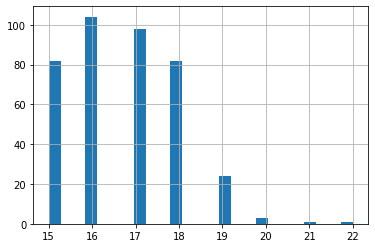

In [12]:
df.age.hist(bins=25)
df.age.describe()

<AxesSubplot:xlabel='age'>

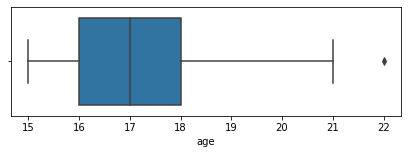

In [13]:
fig = plt.figure(figsize=(7, 2))
sns.boxplot(data=df, x='age')

*Несмотря на наличие значения возраста 22, его можно не считать выбросом, так как оно принадлежит условиям датасета (возраст от 15 до 22)*

#### Medu

count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

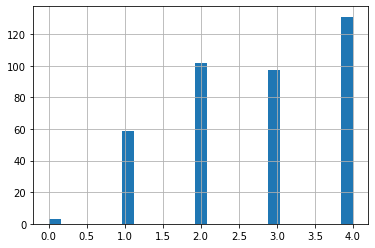

In [14]:
df.Medu.hist(bins=25)
df.Medu.describe()

In [15]:
info_column(df, 'Medu')

,Medu
4.0,131
2.0,102
3.0,97
1.0,59
0.0,3


Уникальных значений: 5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Medu    392 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


#### Fedu

,Fedu
2.0,106
3.0,96
4.0,88
1.0,78
0.0,2
40.0,1


Уникальных значений: 6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fedu    371 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


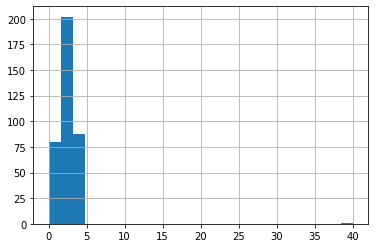

In [16]:
df.Fedu.hist(bins=25)
info_column(df, 'Fedu')

Присутствует явный выброс: значение 40

In [17]:
df = df.loc[df.Fedu < 5]

<AxesSubplot:>

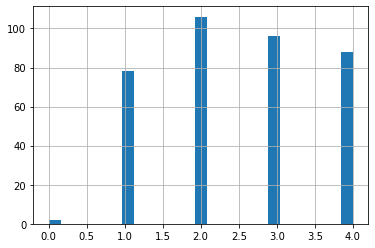

In [18]:
df.Fedu.hist(bins=25)

#### traveltime

,traveltime
1.0,225
2.0,92
3.0,21
4.0,7


Уникальных значений: 4
<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   traveltime  345 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


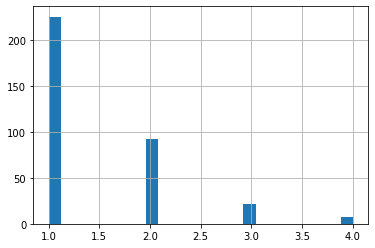

In [19]:
df.traveltime .hist(bins=25)
info_column(df, 'traveltime')

#### studytime

,studytime
2.0,182
1.0,98
3.0,58
4.0,25


Уникальных значений: 4
<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   studytime  363 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


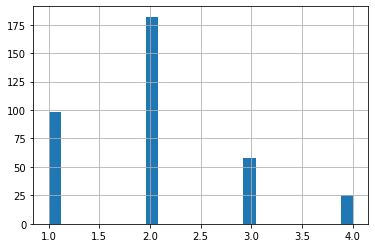

In [20]:
df.studytime .hist(bins=25)
info_column(df, 'studytime')

#### failures

,failures
0.0,277
1.0,45
3.0,15
2.0,14


Уникальных значений: 4
<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   failures  351 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


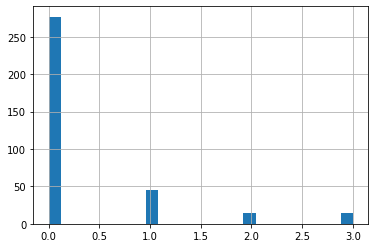

In [21]:
df.failures.hist(bins=25)
info_column(df, 'failures')

#### granular

,granular
-6.0,182
-3.0,98
-9.0,58
-12.0,25


Уникальных значений: 4
<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   granular  363 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


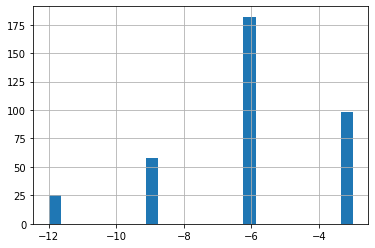

In [22]:
df.granular.hist(bins=25)
info_column(df, 'granular')

<AxesSubplot:xlabel='granular'>

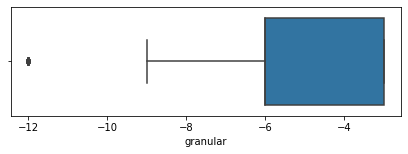

In [23]:
fig = plt.figure(figsize=(7, 2))
sns.boxplot(data=df, x='granular')

Непонятная переменная, пока не будем трогать

#### famrel

,famrel
4.0,168
5.0,95
3.0,59
2.0,16
1.0,7
-1.0,1


Уникальных значений: 6
<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   famrel  346 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


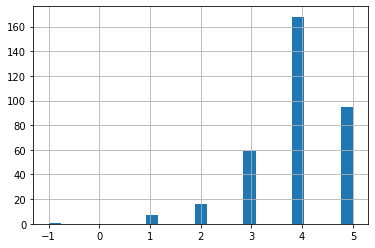

In [24]:
df.famrel.hist(bins=25)
info_column(df, 'famrel')

Значение в -1 не имеет смысла, избавимся от него

<AxesSubplot:>

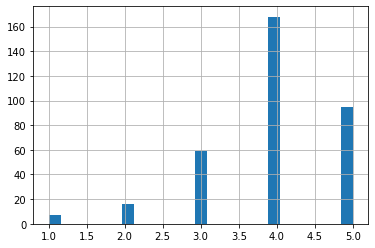

In [25]:
df = df.loc[df.famrel > 0]
df.famrel.hist(bins=25)

#### freetime

,freetime
3.0,134
4.0,97
2.0,54
5.0,34
1.0,17


Уникальных значений: 5
<class 'pandas.core.frame.DataFrame'>
Int64Index: 345 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   freetime  336 non-null    float64
dtypes: float64(1)
memory usage: 5.4 KB


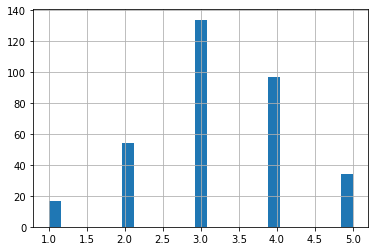

In [26]:
df.freetime.hist(bins=25)
info_column(df, 'freetime')

#### goout

,goout
3.0,115
2.0,87
4.0,71
5.0,45
1.0,19


Уникальных значений: 5
<class 'pandas.core.frame.DataFrame'>
Int64Index: 345 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   goout   337 non-null    float64
dtypes: float64(1)
memory usage: 5.4 KB


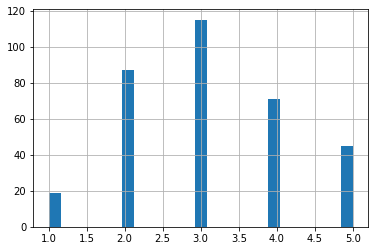

In [27]:
df.goout.hist(bins=25)
info_column(df, 'goout')

#### health

,health
5.0,111
3.0,81
4.0,58
1.0,42
2.0,40


Уникальных значений: 5
<class 'pandas.core.frame.DataFrame'>
Int64Index: 345 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   health  332 non-null    float64
dtypes: float64(1)
memory usage: 5.4 KB


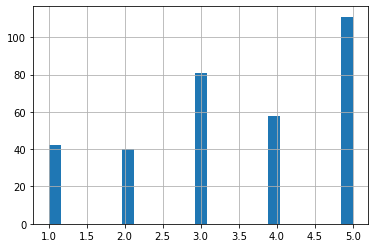

In [28]:
df.health.hist(bins=25)
info_column(df, 'health')

#### absences

count    333.000000
mean       7.315315
std       24.755302
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

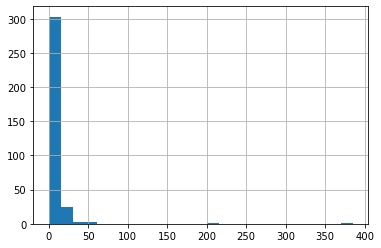

In [29]:
df.absences.hist(bins=25)
df.absences.describe()

<AxesSubplot:xlabel='absences'>

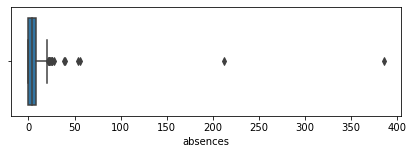

In [30]:
fig = plt.figure(figsize=(7, 2))
sns.boxplot(data=df, x='absences')

Данные распределены ассиметрично. Попробуем прологарифмировать

In [31]:
df.absences = df.absences.apply(lambda x: np.log(x+1))

<AxesSubplot:xlabel='absences'>

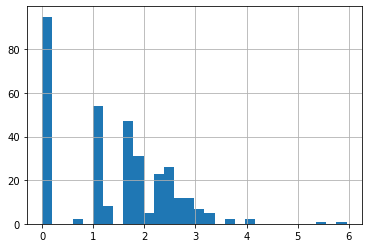

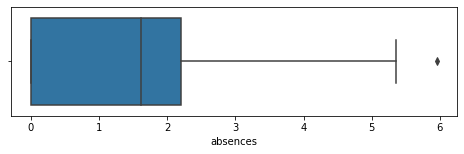

In [32]:
df.absences.hist(bins=30)
fig = plt.figure(figsize=(8, 2))
sns.boxplot(data=df, x='absences')

#### score

count    339.000000
mean      52.477876
std       22.556214
min        0.000000
25%       42.500000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

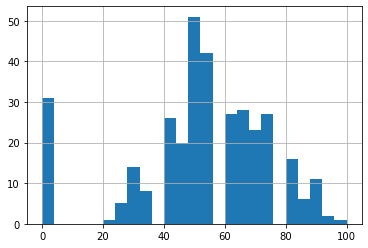

In [33]:
df.score.hist(bins=25)
df.score.describe()

<AxesSubplot:xlabel='score'>

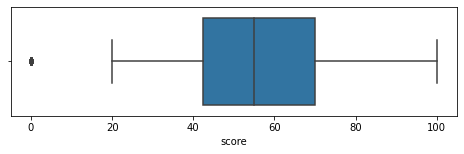

In [34]:
fig = plt.figure(figsize=(8, 2))
sns.boxplot(data=df, x='score')

Избавимся от выбросов

count    308.000000
mean      57.759740
std       15.940057
min       20.000000
25%       50.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

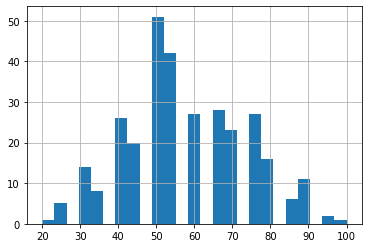

In [35]:
df = df.loc[df.score > 10]
df.score.hist(bins=25)
df.score.describe()

# Корреляционный анализ

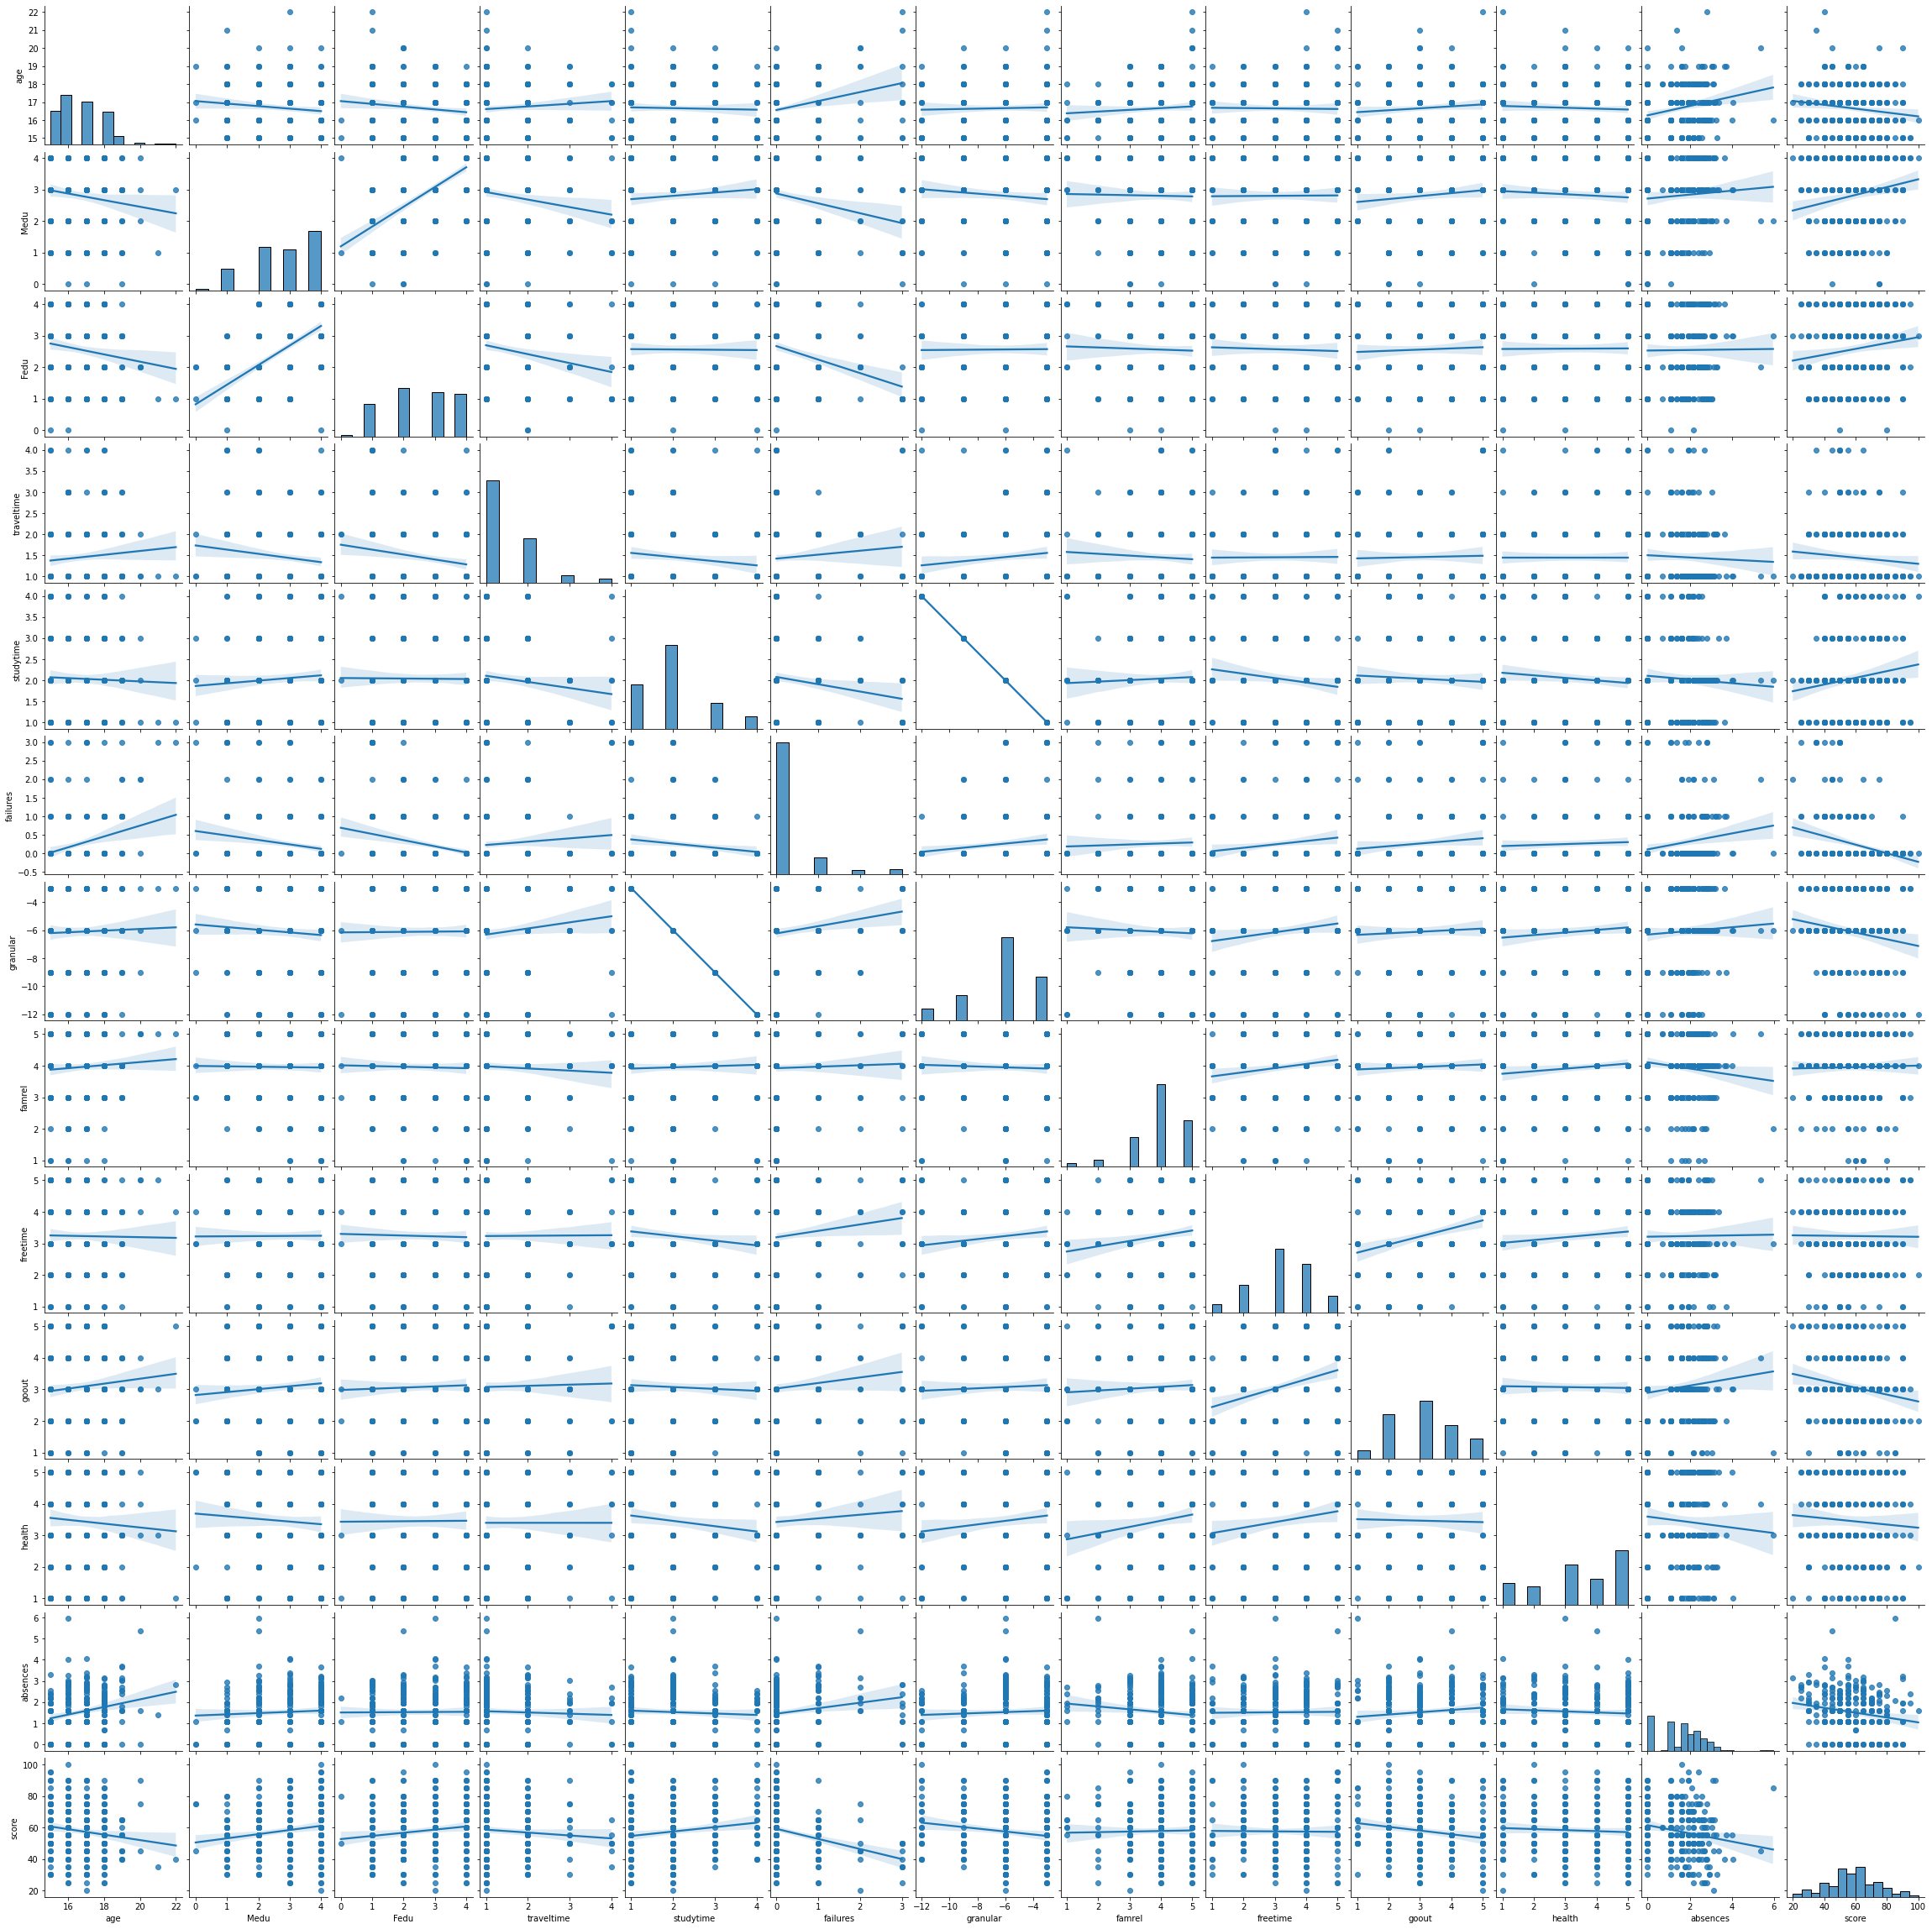

In [36]:
sns.pairplot(df, kind='reg')

In [37]:
df.corr()

,age,Medu,Fedu,traveltime,studytime,failures,granular,famrel,freetime,goout,health,absences,score
age,1.000000,-0.120544,-0.132904,0.081953,-0.029029,0.268951,0.029029,0.067594,-0.013682,0.091383,-0.054718,0.215375,-0.135764
Medu,-0.120544,1.000000,0.623277,-0.153984,0.081203,-0.193629,-0.081203,-0.015481,0.006043,0.093004,-0.064927,0.060477,0.180558
Fedu,-0.132904,0.623277,1.000000,-0.181685,-0.007760,-0.266626,0.007760,-0.027716,-0.027693,0.037420,0.006017,0.008078,0.136063
traveltime,0.081953,-0.153984,-0.181685,1.000000,-0.119623,0.091287,0.119623,-0.054459,0.005918,0.023772,-0.000081,-0.039531,-0.081853
studytime,-0.029029,0.081203,-0.007760,-0.119623,1.000000,-0.138870,-1.000000,0.037804,-0.123678,-0.047060,-0.100978,-0.054154,0.149390
failures,0.268951,-0.193629,-0.266626,0.091287,-0.138870,1.000000,0.138870,0.035149,0.136043,0.111910,0.055280,0.166638,-0.272112
granular,0.029029,-0.081203,0.007760,0.119623,-1.000000,0.138870,1.000000,-0.037804,0.123678,0.047060,0.100978,0.054154,-0.149390
famrel,0.067594,-0.015481,-0.027716,-0.054459,0.037804,0.035149,-0.037804,1.000000,0.147663,0.047466,0.125532,-0.115497,0.020343
freetime,-0.013682,0.006043,-0.027693,0.005918,-0.123678,0.136043,0.123678,0.147663,1.000000,0.273381,0.124335,0.011048,-0.009284
goout,0.091383,0.093004,0.037420,0.023772,-0.047060,0.111910,0.047060,0.047466,0.273381,1.000000,-0.017961,0.110837,-0.160280


Из анализа очевидно, что столбец granular обратно пропорционален столбцу studytime, избавимся от него.

In [38]:
df = df.drop('granular', axis=1)

In [39]:
df.corr()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.120544,-0.132904,0.081953,-0.029029,0.268951,0.067594,-0.013682,0.091383,-0.054718,0.215375,-0.135764
Medu,-0.120544,1.000000,0.623277,-0.153984,0.081203,-0.193629,-0.015481,0.006043,0.093004,-0.064927,0.060477,0.180558
Fedu,-0.132904,0.623277,1.000000,-0.181685,-0.007760,-0.266626,-0.027716,-0.027693,0.037420,0.006017,0.008078,0.136063
traveltime,0.081953,-0.153984,-0.181685,1.000000,-0.119623,0.091287,-0.054459,0.005918,0.023772,-0.000081,-0.039531,-0.081853
studytime,-0.029029,0.081203,-0.007760,-0.119623,1.000000,-0.138870,0.037804,-0.123678,-0.047060,-0.100978,-0.054154,0.149390
failures,0.268951,-0.193629,-0.266626,0.091287,-0.138870,1.000000,0.035149,0.136043,0.111910,0.055280,0.166638,-0.272112
famrel,0.067594,-0.015481,-0.027716,-0.054459,0.037804,0.035149,1.000000,0.147663,0.047466,0.125532,-0.115497,0.020343
freetime,-0.013682,0.006043,-0.027693,0.005918,-0.123678,0.136043,0.147663,1.000000,0.273381,0.124335,0.011048,-0.009284
goout,0.091383,0.093004,0.037420,0.023772,-0.047060,0.111910,0.047466,0.273381,1.000000,-0.017961,0.110837,-0.160280
health,-0.054718,-0.064927,0.006017,-0.000081,-0.100978,0.055280,0.125532,0.124335,-0.017961,1.000000,-0.065864,-0.056890


Можно было бы отсортировать столбец score по значению модуля коэффициента корреляции и посмотреть, какие переменные сильнее всего коррелируют. Но тогда не будет учтено, что переменные в этом столбце не являются абсолютно независимыми. Для устранения этого недостатка используем значение коэффициента детерминации — это доля дисперсии зависимой переменной, объясняемая рассматриваемой моделью. В зависимости от наличия определённых переменных в модели, связь между содержащимися в ней переменными и целевым параметром прослеживается наилучшим образом.

In [40]:
# Рекурсивно переберём все сочетания переменных
feats = {'age', 'Medu', 'Fedu', 'traveltime', 'studytime',
         'failures', 'famrel', 'freetime', 'goout', 'health', 'absences'}

# Найдём такой набор фичей, что R-squared максимальна
res = set()
brute_force(feats, '', res)
res.remove('')
res

{'famrel + absences + Fedu + traveltime + health + failures + age + studytime',
 'freetime + Fedu + Medu + traveltime + health + studytime + age',
 'absences + Medu + traveltime + health + age + studytime',
 'famrel + absences + Fedu + Medu + traveltime + health',
 'famrel + Fedu + traveltime + age',
 'Fedu + goout + studytime',
 'famrel + absences + Fedu + health + failures + goout + age',
 'Fedu + Medu + health + studytime + age',
 'famrel + Fedu + Medu + traveltime',
 'famrel + Medu + health + failures + goout',
 'famrel + freetime + Medu + traveltime + age',
 'famrel + absences + Medu + health + studytime + goout',
 'freetime + Fedu + traveltime + health + studytime + goout',
 'freetime + Fedu + traveltime + studytime',
 'freetime + traveltime + failures + studytime',
 'freetime + absences + traveltime + health + studytime',
 'Fedu + Medu + age + studytime',
 'famrel + absences + Fedu + Medu + failures',
 'absences + Fedu + traveltime + age',
 'famrel + absences + Medu + health + f

In [41]:
results = {}
# Теперь посчитаем Adjusted R-Squared для каждого сочетания
for formula in res:
    lm = smf.ols(formula='score ~ ' + formula, data=df).fit()
    results[formula] = f'{lm.rsquared_adj:.3}'

# выведем отсортированные результаты на экран
d = sorted(results.items(), key=lambda x: x[1], reverse=True)
for i in d:
    print(i[1], '\t', i[0])

0.157 	 absences + Medu + traveltime + failures + studytime + goout
0.157 	 absences + Medu + traveltime + failures + goout + studytime
0.155 	 absences + Fedu + Medu + traveltime + failures + studytime + goout
0.155 	 absences + Fedu + Medu + traveltime + failures + goout + studytime
0.153 	 absences + Medu + traveltime + failures + goout + studytime + age
0.153 	 famrel + absences + Medu + traveltime + failures + goout + studytime
0.153 	 famrel + absences + Medu + traveltime + failures + studytime + goout
0.153 	 absences + Medu + traveltime + failures + studytime + goout + age
0.152 	 absences + Fedu + Medu + traveltime + failures + goout + studytime + age
0.152 	 absences + Fedu + Medu + traveltime + failures + studytime + goout + age
0.152 	 famrel + absences + Fedu + Medu + traveltime + failures + studytime + goout
0.152 	 famrel + absences + Fedu + Medu + traveltime + failures + goout + studytime
0.151 	 absences + Medu + traveltime + failures + goout
0.151 	 freetime + absence

Оставим формулу:  
failures + absences + Medu + traveltime + goout + studytime

# Анализ номинативных переменных

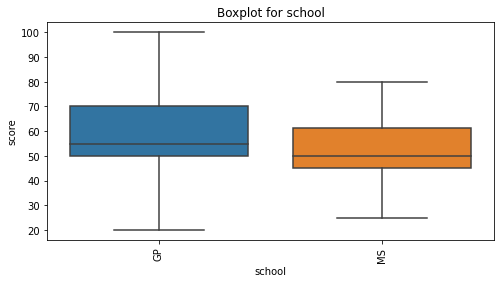

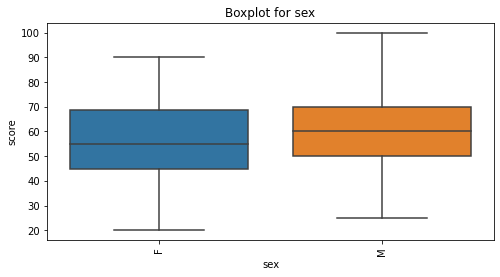

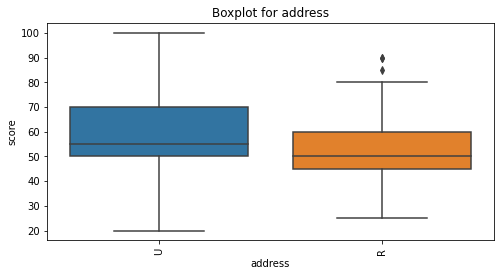

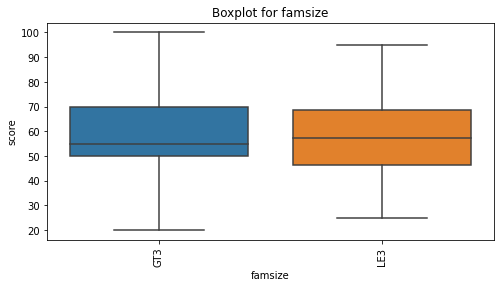

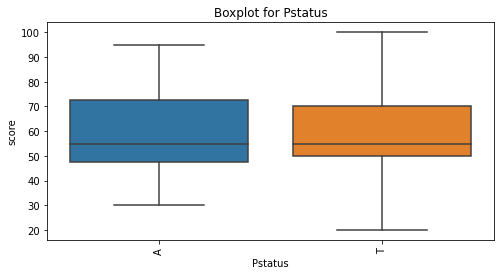

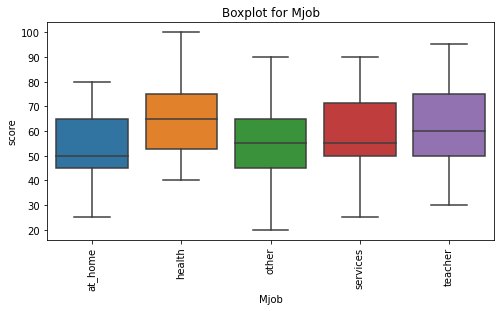

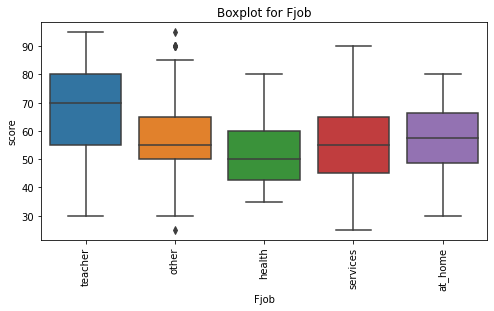

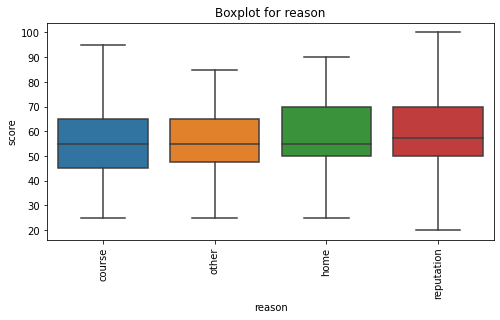

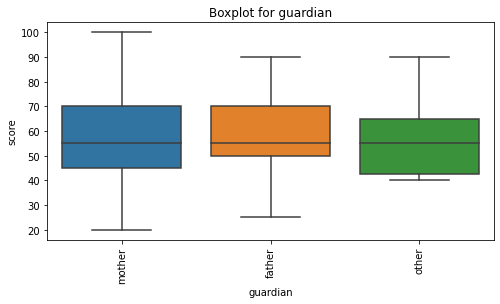

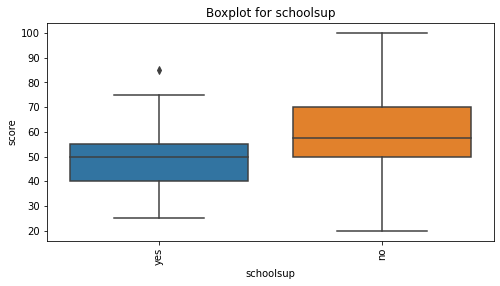

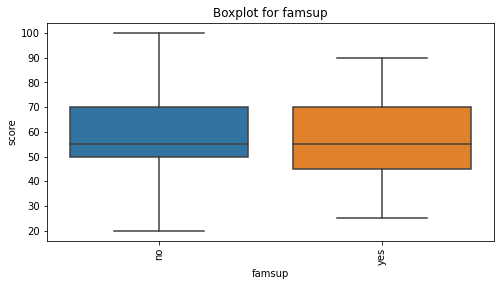

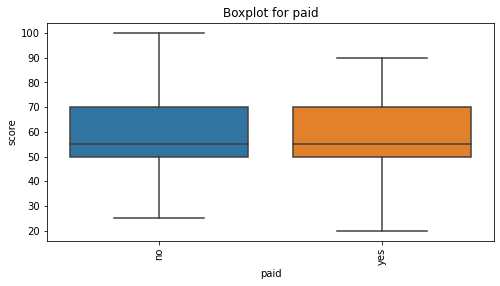

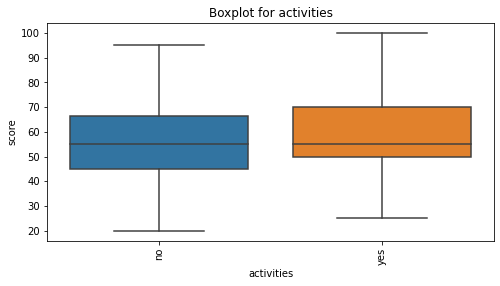

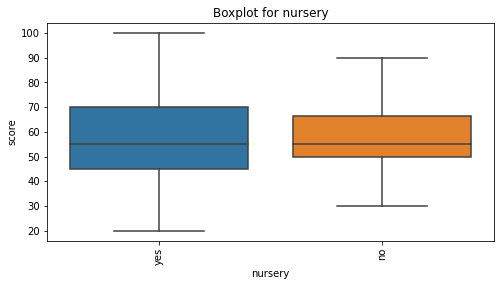

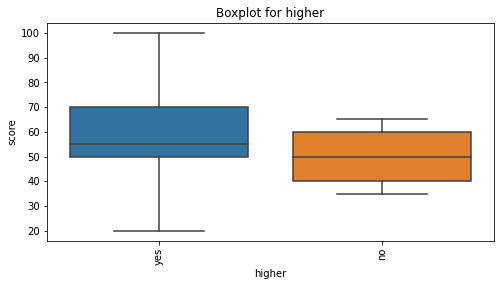

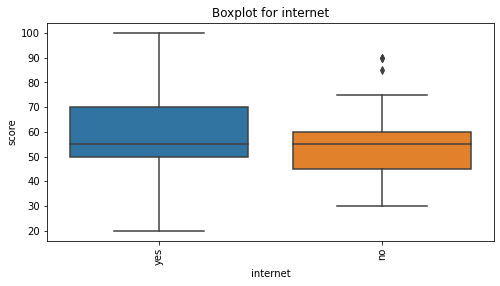

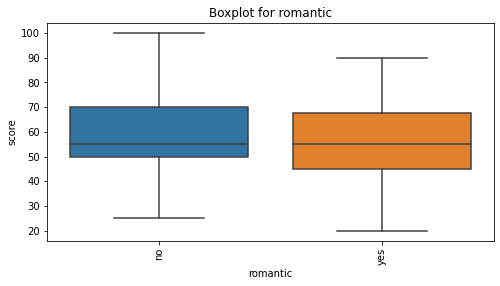

In [42]:
for col in df.columns:
    if col != 'score' and df[col].dtype == 'object':
        get_boxplot(df, col, 'score')

In [43]:
for col in df.columns:
    if col != 'score' and df[col].dtype == 'object':
        get_stat_dif(df, col, 'score')

Найдены статистически значимые различия для колонки address
R U
Найдены статистически значимые различия для колонки Mjob
health at_home
Найдены статистически значимые различия для колонки Fjob
teacher other
Найдены статистически значимые различия для колонки Fjob
teacher services
Найдены статистически значимые различия для колонки schoolsup
yes no


## Поправка Бонферони может быть излишне консервативна, проверим с помощью критерия Тьюки:

In [44]:
columns_in = []

for col in df.columns:
    if col != 'score' and df[col].dtype == 'object':
        columns_in.append(col)

find_razl(df, columns_in, 'score', 10, 0.05)

,group1,group2,meandiff,p-adj,lower,upper,reject,feature
1,R,U,4.9038,0.0290,0.5066,9.3011,True,address
1,at_home,health,10.6602,0.0405,0.2910,21.0294,True,Mjob
9,other,teacher,10.3213,0.0212,1.0211,19.6215,True,Fjob
10,services,teacher,10.7877,0.0251,0.8814,20.6940,True,Fjob
1,no,yes,-10.1503,0.0010,-15.2693,-5.0313,True,schoolsup


Найдены статистически значимые различия в: 
Fjob         2
address      1
Mjob         1
schoolsup    1
Name: feature, dtype: int64


### **Результаты аналогичные, но проверить стоило**

## Рассмотрим более детально:

### Fjob

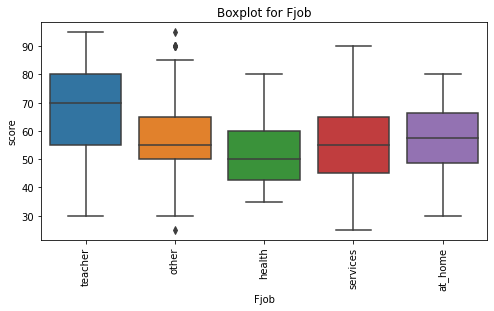

In [45]:
get_boxplot(df, 'Fjob', 'score')

Различия в группах:  
**other** и **teacher**	  
**services** и **teacher**

**Вывод**: ученики, чей отец работает учителем, учатся лучше, чем ребёнок отца, работающего на гос. службе и прочих, не включённых в перечень, профессиях

### Mjob

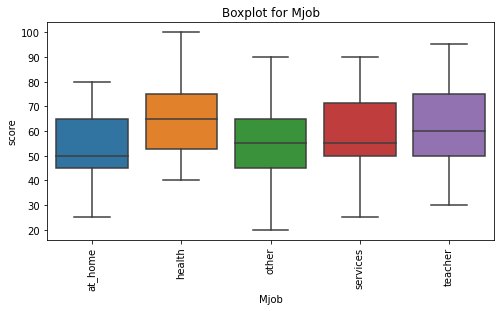

In [46]:
get_boxplot(df, 'Mjob', 'score')

**Вывод**: ученики, чья мать работает в сфере здравоохранения, учатся лучше, чем ребёнок неработающей матери

### address

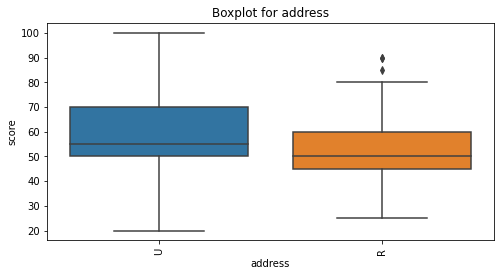

In [47]:
get_boxplot(df, 'address', 'score')

**Вывод**: ученики в городе сдают экзамены в среднем лучше, чем ученики за городом

### schoolsup

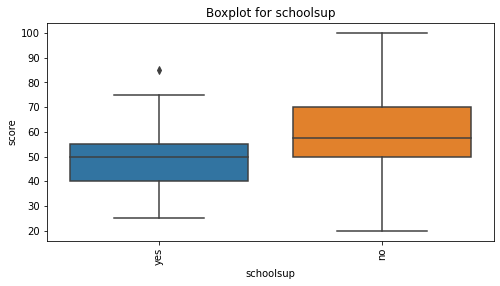

In [48]:
get_boxplot(df, 'schoolsup', 'score')

**Вывод**: ученики без дополнительной образовательной поддержки в среднем сдают экзамены лучше, чем с ней. Что может быть следствием того, что поддержку оказывают более слабым ученикам.

# Выводы

- В данных достаточно мало пустых значений.
- Выбросы найдены в столбцах: Fedu и score, что позволяет сделать вывод о том, что данные достаточно чистые.
- Присутствует лишний столбец granular, который повторяет столбец studytime с обратной корреляцией.
- Для столбца absences применено логарифмирование с целью снижения влияния больших значений.

## Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели:
Из числовых переменных: **failures + absences + Medu + traveltime + goout + studytime**  
Из номинативных переменных: **Fjob         address      Mjob         schoolsup**

## **Зависимости, которые будут использованы в модели**
Из числовых переменных:
- С ростом "failures" целевой параметр уменьшится на -0.272112 *(при неизменных остальных перменных). Ученики, имеющие внеучебные неудачи, менее успешны в учёбе.  
- С ростом "Medu" целевой параметр увеличится на 0.180558 (*). Чем более образованы родители, тем лучше они влияют на образованность ребёнка.
- С ростом "absences" целевой параметр уменьшится на -0.172132 (*). Ученики, пропускающие занятия, хуже учатся.
- С ростом "goout" целевой параметр уменьшится на -0.160280 (*). Ученики, проводящие больше времени с друзьями, хуже учатся.
- С ростом "studytime" целевой параметр увеличится на 0.149390 (*). Ученики, уделяющие больше времени учёбе, лучше учатся.
- С ростом "traveltime" целевой параметр уменьшится на -0.081853 (*). Ученики, живущие дальше от школы, менее эффективно учатся.

Из номинативных переменных:
- Ученики, чей отец работает учителем, учатся лучше, чем ребёнок отца, работающего на гос. службе и прочих, не включённых в перечень, профессиях
- Ученики, чья мать работает в сфере здравоохранения, учатся лучше, чем ребёнок неработающей матери
- Ученики в городе сдают экзамены в среднем лучше, чем ученики за городом
- Ученики без дополнительной образовательной поддержки в среднем сдают экзамены лучше, чем с ней. Что может быть следствием того, что поддержку оказывают более слабым ученикам.


In [49]:
df_for_model = df.loc[:, ['failures', 'absences', 'Medu', 'traveltime',
                          'goout', 'studytime', 'Fjob', 'address', 'Mjob', 'schoolsup', 'score']]
df_for_model.head()

,failures,absences,Medu,traveltime,goout,studytime,Fjob,address,Mjob,schoolsup,score
0,0.0,1.945910,4.0,2.0,4.0,2.0,teacher,U,at_home,yes,30.0
1,0.0,1.609438,1.0,1.0,3.0,2.0,other,U,at_home,no,30.0
2,3.0,2.397895,1.0,1.0,2.0,2.0,other,U,at_home,yes,50.0
3,0.0,1.098612,4.0,1.0,2.0,3.0,NaN,U,health,no,75.0
4,0.0,1.609438,3.0,1.0,2.0,2.0,other,U,other,no,50.0
